In [41]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

feature_name_df = pd.read_csv('./csv/UCI HAR Dataset/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

feature_name = feature_name_df.iloc[:, 1].values.tolist()
print("10개 추출: ", feature_name[:10])

10개 추출:  ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [42]:
# Check Duplicate

feature_dup_df = feature_name_df.groupby('column_name').count()
print((feature_dup_df['column_index']>1).count())
feature_dup_df[feature_dup_df['column_index']>1].head()

477


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [43]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()

    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)

    return new_feature_name_df

In [44]:
import pandas as pd

def get_human_dataset():
    feature_name_df = pd.read_csv('./csv/UCI HAR Dataset/features.txt', sep='\s+', header=None, names=['column_index','column_name'])

    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    X_train = pd.read_csv('./csv/UCI HAR Dataset/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./csv/UCI HAR Dataset/test/X_test.txt', sep='\s+', names=feature_name)

    y_train = pd.read_csv('./csv/UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./csv/UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None, names=['action'])

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [45]:
print("Training Dataset INFO")
print(X_train.info())

Training Dataset INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [46]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [47]:
X_train.isna().sum().sum()

0

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)

pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0: .4f}'.format(accuracy))
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도:  0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [49]:
from sklearn.model_selection import GridSearchCV

params={
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0: .4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


In [50]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [51]:
max_depths = [6, 8, 10, 12, 16, 20, 24]

for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_Depth = {0} 정확도: {1: .4f}'.format(depth, accuracy))

max_Depth = 6 정확도:  0.8558
max_Depth = 8 정확도:  0.8707
max_Depth = 10 정확도:  0.8673
max_Depth = 12 정확도:  0.8646
max_Depth = 16 정확도:  0.8575
max_Depth = 20 정확도:  0.8548
max_Depth = 24 정확도:  0.8548


In [52]:
params = {
    'max_depth' : [8, 12, 16, 20],
    'min_samples_split' : [16,24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0: .4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터: ', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치:  0.8549
GridSearchCV 최적 하이퍼 파라미터:  {'max_depth': 8, 'min_samples_split': 16}


In [53]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도 : {0: .4f}'.format(accuracy))

결정 트리 예측 정확도 :  0.8717


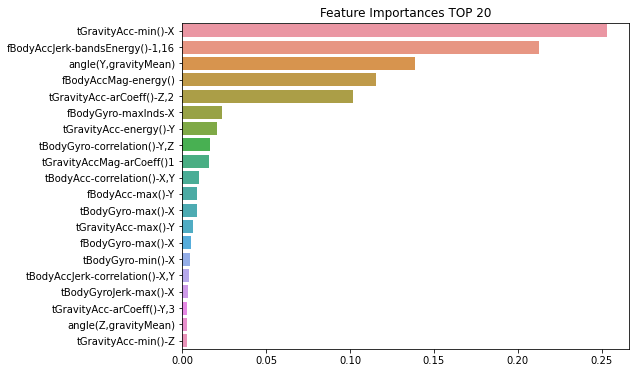

In [55]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature Importances TOP 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()